### Main Project 1 script

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.datasets import fetch_20newsgroups

np.random.seed(42)
random.seed(42)

In [2]:
categories = ['comp.graphics', 'comp.os.ms-windows.misc',
              'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware',
              'rec.autos', 'rec.motorcycles',
              'rec.sport.baseball', 'rec.sport.hockey']
train_dataset = fetch_20newsgroups(subset='train', categories=categories, shuffle=True, random_state=42)
test_dataset = fetch_20newsgroups(subset='test', categories=categories, shuffle=True, random_state=42)

#### Question 1

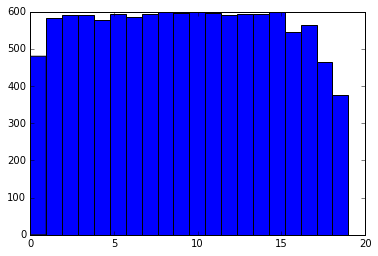

In [3]:
# Fetch all 20 news groups categories and plot a histogram of the training documents.

newsgroups_train = fetch_20newsgroups(subset='train', shuffle=True, random_state=42)
plt.hist(newsgroups_train.target, 20)
plt.show()

#### Question 2

In [4]:
########################################################################################################################
# Fetching 20NewsGroups dataset
from sklearn.datasets import fetch_20newsgroups
# Refer to the offcial document of scikit-learn for detailed usages:
# http://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_20newsgroups.html
categories = ['comp.graphics', 'comp.sys.mac.hardware']
twenty_train = fetch_20newsgroups(subset='train', # choose which subset of the dataset to use; can be 'train', 'test', 'all'
                                  categories=categories, # choose the categories to load; if is `None`, load all categories
                                  shuffle=True,
                                  random_state=42, # set the seed of random number generator when shuffling to make the outcome repeatable across different runs
                                  # remove=['headers'],
                                  )
twenty_test = fetch_20newsgroups(subset='test', categories=categories, shuffle=True, random_state=42)

In [5]:
########################################################################################################################
# Perform lemmatization on dataset

# The lemmatizer is actually pretty complicated, it needs Parts of Speech (POS) tags
import nltk
from nltk import pos_tag
# nltk.download('punkt')#, if you need "tokenizers/punkt/english.pickle", choose it
# nltk.download('averaged_perceptron_tagger')

def penn2morphy(penntag):
    """ Converts Penn Treebank tags to WordNet. """
    morphy_tag = {'NN': 'n', 'JJ': 'a',
                  'VB': 'v', 'RB': 'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n'


# def lemmatize_sent(list_word, wnl):
#     # Text input is string, returns array of lowercased strings(words).
#     return [wnl.lemmatize(word.lower(), pos=penn2morphy(tag))
#             for word, tag in pos_tag(list_word)]


wnl = nltk.wordnet.WordNetLemmatizer()
def lemmatize_training(text):
    # Text input is string, returns array of lowercased strings(words).
    return [wnl.lemmatize(word.lower(), pos=penn2morphy(tag))
            for word, tag in pos_tag(nltk.word_tokenize(text))]


# TODO: should this filter out the following numbers too? "4-5" "c650"
def filter_numbers(text_array):
    # Filter out any numbers found in the array of strings
    output = []
    for s in text_array:
        if not s.isdigit():
            # if not a digit...
            try:
                # if a float, filter out
                float(s)
            except ValueError:
                # if not a float, add to output
                output.append(s)
        else:
            # if a digit, filter out
            pass
    return output


def array_to_string(text_array, delimeter=""):
    # Converts an array back into a string of words using the provided delimeter to add between each word
    output = ""
    for s in text_array:
        output = output + delimeter + s
    return output


def lemmatize_and_filter(documents):
    # Performs lemmatization, and number filtering on the given documents
    lemmatized_data = []
    for i in documents:
        # lemmatize the document:
        training_tagged = pos_tag(nltk.word_tokenize(i))
        lemmatized_array = lemmatize_training(i)

        # remove numbers from document:
        filtered_array = filter_numbers(lemmatized_array)

        # reassemble back to string:
        lemmatized_string = array_to_string(filtered_array, ' ')

        # add to final data list
        # print(lemmatized_string)
        lemmatized_data.append(lemmatized_string)

    return lemmatized_data


# print(lemmatized_data[0])
lemmatized_training = lemmatize_and_filter(twenty_train.data)
lemmatized_testing = lemmatize_and_filter(twenty_test.data)

In [6]:
########################################################################################################################
# Push lemmatized documents through CountVectorizer

# count_vect = CountVectorizer(min_df=3)
from sklearn.feature_extraction.text import CountVectorizer

# do for training
count_vect = CountVectorizer(min_df=3, stop_words='english')
X_lemmatized_train_counts = count_vect.fit_transform(lemmatized_training)

# do for testing
X_lemmatized_test_counts = count_vect.transform(lemmatized_testing)

In [7]:
########################################################################################################################
# Report shapes of TF-IDF matrices

from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()

# do for training
X_lemmatized_train_tfidf = tfidf_transformer.fit_transform(X_lemmatized_train_counts)

print(X_lemmatized_train_tfidf.shape)
print('-' * 20)
print(X_lemmatized_train_counts.toarray()[:30, :5])
print('-' * 20)
print(X_lemmatized_train_tfidf.toarray()[:30, :5])

# do for testing
X_lemmatized_test_tfidf = tfidf_transformer.transform(X_lemmatized_test_counts)

print(X_lemmatized_test_tfidf.shape)
print('-' * 20)
print(X_lemmatized_test_counts.toarray()[:30, :5])
print('-' * 20)
print(X_lemmatized_test_tfidf.toarray()[:30, :5])

(1162, 5167)
--------------------
[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 1 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
--------------------
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.      

#### Question 3

In [8]:
# Perform LSI using the truncated SVD

from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=50, random_state=42)
X_lsi_train_reduced = svd.fit_transform(X_lemmatized_train_tfidf)
Y_lsi_train_reduced = svd.components_
print(X_lsi_train_reduced.shape)
print(svd.components_.shape)

X_lsi_test_reduced = svd.transform(X_lemmatized_test_tfidf)
Y_lsi_test_reduced = svd.components_
print(X_lsi_train_reduced.shape)
print(svd.components_.shape)

(1162, 50)
(50, 5167)
(1162, 50)
(50, 5167)


In [9]:
# Perform NMF

from sklearn.decomposition import NMF

model = NMF(n_components=50, init='random', random_state=42)
W_nmf_train_reduced = model.fit_transform(X_lemmatized_train_tfidf)
H_nmf_train_reduced = model.components_

print(W_nmf_train_reduced.shape)
print(H_nmf_train_reduced.shape)

W_nmf_test_reduced = model.transform(X_lemmatized_test_tfidf)
H_nmf_test_reduced = model.components_

(1162, 50)
(50, 5167)


In [10]:
# Compare LSI and NMF

nmf_val = np.linalg.norm(X_lemmatized_train_tfidf - np.matmul(W_nmf_train_reduced, H_nmf_train_reduced), 'fro')
lsi_val = np.linalg.norm(X_lemmatized_train_tfidf - np.matmul(X_lsi_train_reduced, Y_lsi_train_reduced), 'fro')

print('NMF: ', nmf_val)
print('LSI: ', lsi_val)

NMF:  30.10726773762609
LSI:  29.800199080327772


#### Question 5

In [16]:
# Train an unregularized logistic regression classifier.

from sklearn.linear_model import LogisticRegression

# To be unregularized, we make the inverse of the regularization strength C 
# to be large to approximate an unregularized classifier.
clf = LogisticRegression(random_state=42, C=500, solver='lbfgs').fit(X_lsi_train_reduced, twenty_train.target)

# score = clf.decision_function(X_lsi_test_reduced)
predicted = clf.predict(X_lsi_test_reduced)


In [17]:
# Find confusion matrix, accuracy, precision-recall, and F-1 scores

# Confusion matrix
from sklearn.metrics import confusion_matrix

print('Confusion matrix: \n', confusion_matrix(twenty_test.target, predicted))

# Accuracy
from sklearn.metrics import accuracy_score

print('Accuracy: ', accuracy_score(twenty_test.target, predicted))

# Average precision-recall score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

print('Average precision-recall score:', average_precision_score(twenty_test.target, predicted))
print('Precision score: ', precision_score(twenty_test.target, predicted))
print('Recall score: ', recall_score(twenty_test.target, predicted))

# F-1 score
from sklearn.metrics import f1_score

print('F-1 score:', f1_score(twenty_test.target, predicted))

Confusion matrix: 
 [[355  34]
 [ 12 373]]
Accuracy:  0.9405684754521964
Average precision-recall score: 0.9034007456840438
Precision score:  0.9164619164619164
Recall score:  0.9688311688311688
F-1 score: 0.9419191919191919


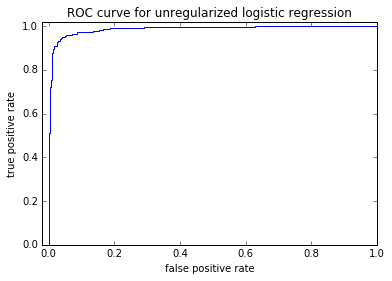

In [18]:
# ROC curve

from sklearn.metrics import roc_curve

score = clf.decision_function(X_lsi_test_reduced)
fpr, tpr, thresholds = roc_curve(twenty_test.target, score)

plt.figure()
plt.plot(fpr, tpr)
plt.title('ROC curve for unregularized logistic regression')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.xlim(left=-0.02)
plt.ylim(top=1.02)
plt.show()

#### Question 6

In [14]:
########################################################################################################################
# Train a Naive Bayes Gaussian classifier on the reduced TFIDF training set from problem 3

from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
clf = GaussianNB().fit(W_nmf_train_reduced, twenty_train.target)
clf2 = MultinomialNB().fit(W_nmf_train_reduced, twenty_train.target)

In [15]:
########################################################################################################################
# Generate predictions for test set

predicted = clf.predict(W_nmf_test_reduced)
correct = 0
for i, category in enumerate(predicted):
    if category == twenty_test.target[i]:
        correct += 1
    if i < 5:
        print('{} =? {}'.format(twenty_test.target_names[category], twenty_test.target_names[twenty_test.target[i]]))
    elif i == 5:
        print('...\n')
print('Accuracy of NB Gaussian: {}'.format(correct / W_nmf_test_reduced.shape[0]))

comp.graphics =? comp.graphics
comp.sys.mac.hardware =? comp.sys.mac.hardware
comp.sys.mac.hardware =? comp.sys.mac.hardware
comp.graphics =? comp.sys.mac.hardware
comp.graphics =? comp.sys.mac.hardware
...

Accuracy of NB Gaussian: 0.5568475452196382


In [16]:
########################################################################################################################
# Generate predictions for test set

predicted = clf2.predict(W_nmf_test_reduced)
correct = 0
for i, category in enumerate(predicted):
    if category == twenty_test.target[i]:
        correct += 1
    if i < 5:
        print('{} =? {}'.format(twenty_test.target_names[category], twenty_test.target_names[twenty_test.target[i]]))
    elif i == 5:
        print('...\n')
print('Accuracy of NB Gaussian: {}'.format(correct / W_nmf_test_reduced.shape[0]))

comp.graphics =? comp.graphics
comp.sys.mac.hardware =? comp.sys.mac.hardware
comp.sys.mac.hardware =? comp.sys.mac.hardware
comp.graphics =? comp.sys.mac.hardware
comp.sys.mac.hardware =? comp.sys.mac.hardware
...

Accuracy of NB Gaussian: 0.5775193798449613


#### TEST